# EARLI: Evolutionary Algorithm with RL Initialization
# Train usage example

## Setup

### Install

Run the following steps **only if EARLI is not yet installed in your machine** (e.g., no need to install if you use EARLI's docker).

In [ ]:
# Verify Python>=3.10
import sys
print(sys.version)

#### GPU Check

Verify that an NVIDIA GPU is available and accessible.


In [ ]:
import subprocess
import html
from IPython.display import display, HTML

def check_gpu():
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, timeout=5)
        result.check_returncode()
        lines = result.stdout.splitlines()
        gpu_info = lines[2] if len(lines) > 2 else "GPU detected"
        gpu_info_escaped = html.escape(gpu_info)
        display(HTML(f"""
        <div style="border:2px solid #4CAF50;padding:10px;border-radius:10px;background:#e8f5e9;">
            <h3>✅ GPU is enabled</h3>
            <pre>{gpu_info_escaped}</pre>
        </div>
        """))
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired, FileNotFoundError, IndexError) as e:
        display(HTML("""
        <div style="border:2px solid red;padding:15px;border-radius:10px;background:#ffeeee;">
            <h3>⚠️ GPU not detected!</h3>
            <p>This notebook requires a <b>GPU runtime</b>.</p>
            
            <h4>If running in Google Colab:</h4>
            <ol>
              <li>Click on <b>Runtime → Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then click <b>Save</b> and <b>Runtime → Restart runtime</b>.</li>
            </ol>
            
            <h4>If running in Docker:</h4>
            <ol>
              <li>Ensure you have <b>NVIDIA Docker runtime</b> installed (<code>nvidia-docker2</code>)</li>
              <li>Run container with GPU support: <code>docker run --gpus all ...</code></li>
              <li>Or use: <code>docker run --runtime=nvidia ...</code> for older Docker versions</li>
              <li>Verify GPU access: <code>docker run --gpus all nvidia/cuda:12.0.0-base-ubuntu22.04 nvidia-smi</code></li>
            </ol>
            
            <p><b>Additional resources:</b></p>
            <ul>
              <li><a href="https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html" target="_blank">NVIDIA Container Toolkit Installation Guide</a></li>
            </ul>
        </div>
        """))
        return False

check_gpu()

In [ ]:
# Install build tools for compiling C/C++ extensions.
# If you have root on this notebook (e.g. in Google Colab): uncomment.
# Otherwise: install this outside the notebook.
!apt-get update -y && apt-get install -y git build-essential ninja-build

In [ ]:
!pip uninstall -y cuda-python cuda-bindings cuda-core

# For cuda 12
!pip install --upgrade --extra-index-url https://pypi.nvidia.com cuopt-cu12 nvidia-nvjitlink-cu12 rapids-logger==0.1.19

# For cuda 13
# !pip install --upgrade --extra-index-url https://pypi.nvidia.com cuopt-cu13 nvidia-nvjitlink-cu13 rapids-logger==0.1.19

### If Running in colab, please paste the setup code generated in launcher notebook in the below cell

In [ ]:
# If Running in colab, please paste the setup code generated in launcher notebook in the below cell


In [ ]:
!pip install --upgrade --extra-index-url https://pypi.nvidia.com -c constraints.txt git+https://github.com/NVlabs/EARLI.git

### Import

In [1]:
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import yaml
from stable_baselines3 import PPO
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "training_rl_agent_for_vrp.ipynb"

from earli.models.attention_model import PosAttentionModel
from earli.utils.nv import verify_consistent_config
from earli.vrp import VRP
from earli.utils import analysis_utils as utils
from earli import download_data, main, test_injection
import torch

### Download data

Download test dataset of VRP instances in Sao Paulo and Rio, based on the [Olist benchmark](https://github.com/NVlabs/olist-vrp-benchmark).

In [2]:
download_data.main(['--cleanup', '--force'])

test_problems.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 941M/941M [00:22<00:00, 44.7MB/s]


Successfully downloaded to datasets/test_problems.zip
Extracting datasets/test_problems.zip to datasets
Successfully extracted to datasets

Extracted contents in datasets/test_problems:
  vrp-test-size-100-rio-n_problems-256.pkl (10.4 MB)
  vrp-test-size-100-sp-n_problems-256.pkl (10.4 MB)
  vrp-test-size-20-sp-n_problems-256.pkl (0.9 MB)
  vrp-test-size-200-rio-n_problems-256.pkl (40.2 MB)
  vrp-test-size-200-sp-n_problems-256.pkl (40.2 MB)
  vrp-test-size-30-sp-n_problems-256.pkl (1.9 MB)
  vrp-test-size-300-rio-n_problems-256.pkl (89.7 MB)
  vrp-test-size-300-sp-n_problems-256.pkl (89.7 MB)
  vrp-test-size-400-rio-n_problems-256.pkl (158.6 MB)
  vrp-test-size-400-sp-n_problems-256.pkl (158.6 MB)
  vrp-test-size-50-rio-n_problems-256.pkl (2.7 MB)
  vrp-test-size-50-sp-n_problems-256.pkl (2.7 MB)
  vrp-test-size-500-rio-n_problems-256.pkl (247.1 MB)
  vrp-test-size-500-sp-n_problems-256.pkl (247.1 MB)
  vrp-train-size-20-sp-n_problems-1000.pkl (3.5 MB)
  vrp-train-size-30-sp-n_problem

In [4]:
ls -lh datasets/problem_instances/vrp-train-size-20-sp-n_problems-1000.pkl

-rw-r--r-- 1 igreenberg domain-users 3.6M Oct  5 11:58 datasets/problem_instances/vrp-train-size-20-sp-n_problems-1000.pkl


## Train
#### Train config

Train parameters may be modified in `config_train.yaml`.

Key parameters:
* `data_file`: Pickle file that contains the problem instances for training (e.g., one of the files downloaded above).
* `pretrained_fname`: Path of pretrained initial model to be used. We provide several compatible models under `pretrained_models/`.

In [18]:
total_train_steps = 1000000

with open('configs/config_train.yaml') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)
config = verify_consistent_config(config) # optional

env = VRP(config, datafile=config['eval']['data_file'], env_type='eval')

model = PPO(policy=PosAttentionModel, env=env, policy_kwargs={'config': config},
            n_steps=200,
            batch_size=config['train']['batch_size'],
            ent_coef=0)

#### Train

In [19]:
%%time
model.learn(total_train_steps, log_interval=1)

CPU times: user 10min 40s, sys: 737 ms, total: 10min 41s
Wall time: 6min 14s


#### Save model

In [20]:
model_path = config['train']['save_model_path']
print('Saving model to:', model_path)
torch.save({'model_state_dict': model.policy.state_dict()}, model_path)

Saving model to: pretrained_models/new_vrp_model.m


## Test

Run test with the arguments specified in `config_test.yaml`.

Key arguments:
* `pretrained_fname`: set to the model path (printed above).
* `data_file`: for example, if the model trained on `vrp-train-size-20-sp-n_problems-1000.pkl`, you may use for testing `datasets/problem_instances/vrp-test-size-20-sp-n_problems-256.pkl`.

In [21]:
main.main(config_path='configs/config_test.yaml')

Applying RL solver to 256 problem instances...
test time part 1/1: 0:00:00

Local-search duration per problem (for 8 solutions): 0.0004786672070622444 +- 2.9457340083598676e-06 [s]
-------------------------------------
| test/                  |          |
|    mean_game_clocktime | 0.00138  |
|    mean_game_iters     | 21.8     |
|    mean_reward         | -0.601   |
|    std_reward          | 0.109    |
|    total_games         | 256      |
-------------------------------------
Saving logs to: ./outputs/test_logs.pkl


## Analyze test results

#### Load results

In [22]:
with open('outputs/test_logs.pkl', 'rb') as hh:
    results_log = pkl.load(hh)

with open(results_log['problems_path'], 'rb') as hh:
    problems = pkl.load(hh)

#### Calculate average costs

In [23]:
best_sols = results_log['optimal_route']
vehicles = [np.sum([node==0 for node in sol]).item()-1 for sol in best_sols]
costs = [utils.solution_cost(sol, dist_mat).item() for sol, dist_mat in zip(best_sols, problems['distance_matrix'])]
df = pd.DataFrame(dict(method='RL', problem_id=np.arange(len(costs)), vehicles=vehicles, cost=costs))
df

,method,problem_id,vehicles,cost
0,RL,0,2,39127.4
1,RL,1,2,29276.6
2,RL,2,2,31222.0
3,RL,3,3,30925.3
4,RL,4,2,29697.7
...,...,...,...,...
251,RL,251,2,21610.5
252,RL,252,2,30961.7
253,RL,253,1,19751.2
254,RL,254,3,42667.8


In [24]:
print('Mean number of vehicles per problem:', df.vehicles.mean())
print('Mean cost per problem:', df.cost.mean())

Mean number of vehicles per problem: 2.28125
Mean cost per problem: 30119.0828125


#### Visualize solutions

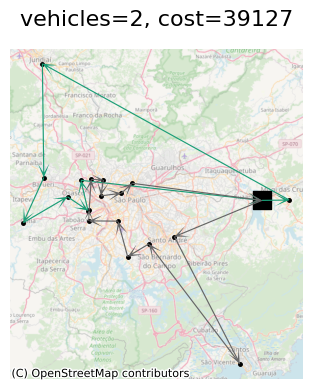

In [26]:
problem_id = 0
utils.display_solution(best_sols[problem_id], problems, problem_id, 'sao_paulo', axsize=(5,4));

#### Compare to cuOpt costs as a reference

Run the cuOpt solver with the arguments specified in `config_cuopt.yaml`.

Key arguments:
* `problems`: Same as `data_file` above.
* `runtimes`: Solver time budget (default: 0.1s).

In [27]:
%%time
test_injection.main(config_path='configs/config_cuopt.yaml')


cuopt
CuOpt version: 25.08.00
Problems: datasets/problem_instances/vrp-test-size-20-sp-n_problems-256.pkl
Solutions: None
Problems: 0-255

SOLVER_RUNTIME = 0.1:
Finished problem 1.001.1/1.256.1.
Finished problem 1.002.1/1.256.1.
Finished problem 1.003.1/1.256.1.
Finished problem 1.004.1/1.256.1.
Finished problem 1.005.1/1.256.1.
Finished problem 1.006.1/1.256.1.
Finished problem 1.007.1/1.256.1.
Finished problem 1.008.1/1.256.1.
Finished problem 1.009.1/1.256.1.
Finished problem 1.010.1/1.256.1.
Finished problem 1.011.1/1.256.1.
Finished problem 1.012.1/1.256.1.
Finished problem 1.013.1/1.256.1.
Finished problem 1.014.1/1.256.1.
Finished problem 1.015.1/1.256.1.
Finished problem 1.016.1/1.256.1.
Finished problem 1.017.1/1.256.1.
Finished problem 1.018.1/1.256.1.
Finished problem 1.019.1/1.256.1.
Finished problem 1.020.1/1.256.1.
Finished problem 1.021.1/1.256.1.
Finished problem 1.022.1/1.256.1.
Finished problem 1.023.1/1.256.1.
Finished problem 1.024.1/1.256.1.
Finished problem 1.025

/home/igreenberg/code/CloneRLOptimizer/inference/rlopt_gitlab_master/rlopt_inference/test_injection.py:400: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rr = rr.groupby(['method', 'total_runtime']).apply(lambda d: is_valid_method(d)).reset_index(drop=True)
/home/igreenberg/code/CloneRLOptimizer/inference/rlopt_gitlab_master/rlopt_inference/test_injection.py:405: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rr = rr.

Read cuOpt stats:

In [28]:
fpath = r'outputs/test_summary_cuopt.pkl'
with open(fpath, 'rb') as hh:
    cuopt_logs = pkl.load(hh)
df = pd.concat([df, cuopt_logs['summary'][df.columns]], ignore_index=True, sort=False)
df

,method,problem_id,vehicles,cost
0,RL,0,2,39127.400000
1,RL,1,2,29276.600000
2,RL,2,2,31222.000000
3,RL,3,3,30925.300000
4,RL,4,2,29697.700000
...,...,...,...,...
507,cuOpt,251,2,20003.099840
508,cuOpt,252,2,28397.900061
509,cuOpt,253,1,18616.399934
510,cuOpt,254,3,40790.700055


Compare vehicles:

Ratio of problems where RL obtained the same number of vehicles as cuOpt: 97.7%


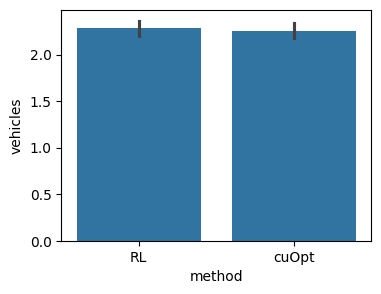

In [29]:
optimal_vehicles_ratio = df.groupby('problem_id').apply(lambda d: d.vehicles.nunique()==1, include_groups=False).mean().item()
print(f'Ratio of problems where RL obtained the same number of vehicles as cuOpt: {100*optimal_vehicles_ratio:.1f}%')

plt.figure(figsize=(4,3))
sns.barplot(data=df, x='method', y='vehicles');

Compare costs:

Average RL cost gap from cuOpt: 7.91%


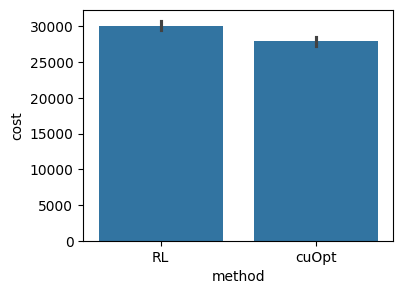

In [30]:
cost_ratio = df[df.method=='RL'].cost.mean() / df[df.method=='cuOpt'].cost.mean()
print(f'Average RL cost gap from cuOpt: {100*(cost_ratio-1):.2f}%')

plt.figure(figsize=(4,3))
sns.barplot(data=df, x='method', y='cost');

## License

SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
